# ODR test
Attempt to do nonlinear Orthogonal Distance Regression (more properly, [Total Least Squares regression](https://en.wikipedia.org/wiki/Total_least_squares)) using MCMC.

I'm hoping that this is as simple as finding an appropriate likelihood function and then just running the sampler.

## References
- `scipy.odr` [docs](https://docs.scipy.org/doc/scipy/reference/odr.html), including the underlying [`ODRPACK` library's user guide](https://docs.scipy.org/doc/external/odrpack_guide.pdf)

In [1]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

## Simulate data
For the first test I'll use a simple linear model with normal errors in both `x` and `y`.

In [4]:
# ground truth
m = 3.0 # slope
b = 1.0 # y intercept

def f_true(x, m, b):
    return m*x+b*np.ones_like(x)

In [5]:
# initialize numpy random number generator
SEED=20240105 #20230728 # seed for rng
rng = np.random.default_rng(SEED)

In [6]:
# errors
sigma_x = 0.1
sigma_y = 0.1

n_points = 10

x_true = np.random.uniform(low=0,high=1,size=n_points)
y_true = f_true(x_true,m,b)

In [7]:
# add errors
x_data = x_true + np.random.normal(loc=0,scale=sigma_x,size=n_points)
y_data = y_true + np.random.normal(loc=0,scale=sigma_y,size=n_points)

In [8]:
# store the data in an array
(data_array := np.array([x_data, y_data]).T)

array([[0.34319078, 2.51294214],
       [0.39426634, 1.84995739],
       [0.64892177, 3.18320158],
       [0.41075989, 2.5944951 ],
       [0.13661206, 1.63380451],
       [0.60723974, 2.61115218],
       [0.64862788, 3.53842791],
       [0.40368962, 2.01199004],
       [0.64754763, 2.65763497],
       [0.29869371, 2.17621716]])

In [9]:
# store the error bars in an array
(std_array := np.array([sigma_x,sigma_y]))

array([0.1, 0.1])

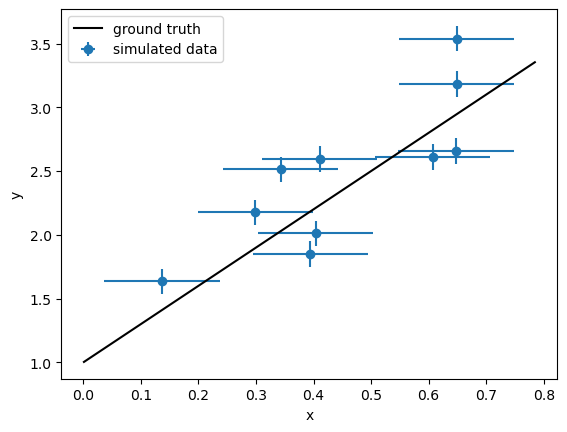

In [10]:
# plot the data
fig, ax=plt.subplots()
ax.errorbar(x=x_data,y=y_data,xerr=sigma_x,yerr=sigma_y,fmt='o',label='simulated data')
ax.set_xlabel('x')
ax.set_ylabel("y")
x_limits=np.array(ax.get_xlim())
ax.plot(x_limits,f_true(x_limits,m,b),'k',label='ground truth')
ax.legend()

In [11]:
def f_implicit(x,y,m,b):
    '''
    Implicit fitting function.  This should nominally equal zero.
    '''
    return y-f_true(x,m,b)

The implicit function that I have here is really just the residual in the $y$-direction.  In other words, I'm doing ordinary least squares below, but with the added steps of using latent variables for the "true" data.  This will give me an answer for the fit, but is it justifiable in any way?  Is it fair to interpret this as a good estimate of the "true" fitting function?  Will this break for some functions or data sets?

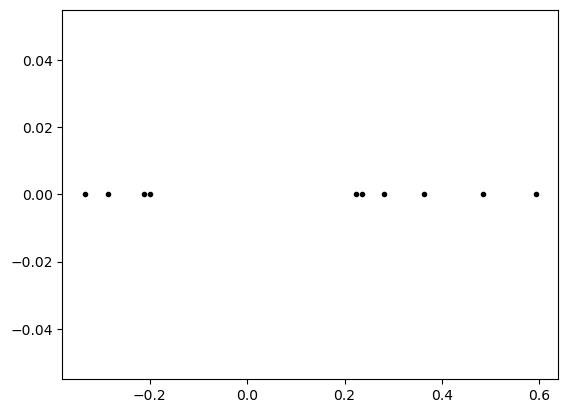

In [12]:
plt.plot(f_implicit(x_data,y_data,m,b),np.zeros_like(x_data),'k.')

The trick I'll use is to convert the implicit function $f(x,y)$ into a probability distribution (or is it likelihood?).  If we're being strict:

$$
p(x,y) = \delta[f(x,y)],
$$

a delta-function distribution.

Let's soften the pdf by approximating the delta function as a normal distribution:

$$
p(x,y) = \frac{1}{\sqrt{2\pi\Delta^2}}\exp\left(-\frac{(f(x,y))^2}{2\Delta^2}\right)
$$

For MCMC we just need the log-likelihood:
$$
LL = -(f(x,y))^2 + \text(contant).
$$

In `pymc` we can add this as a "potential" to the overall likelihood.

In [13]:
with pm.Model() as model:
    x = pm.MutableData('x', x_data, dims="samples")
    y = pm.MutableData('y', y_data, dims="samples")

    # priors for the fitting parameters
    # Uniform distribution is equivalent to max likelihood estimate
    # Use other distributions for Bayesian priors
    m_fit = pm.Uniform('m_fit',lower=0.0,upper=10.0,shape=(1,))
    b_fit = pm.Uniform('b_fit',lower=0.0,upper=10.0,shape=(1,))

    # latent variables
    # assume sigmas are known and correct
    x_latent = pm.Normal('x_latent', mu=x, sigma=sigma_x, dims="samples")
    y_latent = pm.Normal('y_latent', mu=y, sigma=sigma_y, dims='samples')

    # log likelihood function (minus the `score` for normal errors)
    logp = -(f_implicit(x_latent,y_latent,m_fit,b_fit)**2)

    pot = pm.Potential('pot', logp)

    #fit = pm.Normal('fit',mu=f_implicit(x_latent,y_latent,m_fit,b_fit),sigma=0.1,dims="samples",observed=np.zeros(n_points))

In [14]:
with model:
    idata = pm.sample_prior_predictive(500)

/tmp/ipykernel_9258/2174265191.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive(500)
Sampling: [b_fit, m_fit, x_latent, y_latent]


In [15]:
with model:
    pm.model_to_graphviz()

In [16]:
with model:
    idata.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): EquilibriumGraphRewriter max'ed out by local_useless_dimshuffle_makevector.You can safely raise the current threshold of 8.0 with the option `optdb__max_use_ratio`.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_fit, b_fit, x_latent, y_latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [17]:
az.summary(idata,var_names=['m_fit','b_fit'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_fit[0],2.329,1.171,0.132,4.377,0.025,0.020,2018.0,1393.0,1.0
b_fit[0],1.424,0.581,0.342,2.476,0.013,0.009,2000.0,1154.0,1.0


array([[<Axes: title={'center': 'm_fit'}>,
        <Axes: title={'center': 'm_fit'}>],
       [<Axes: title={'center': 'b_fit'}>,
        <Axes: title={'center': 'b_fit'}>]], dtype=object)

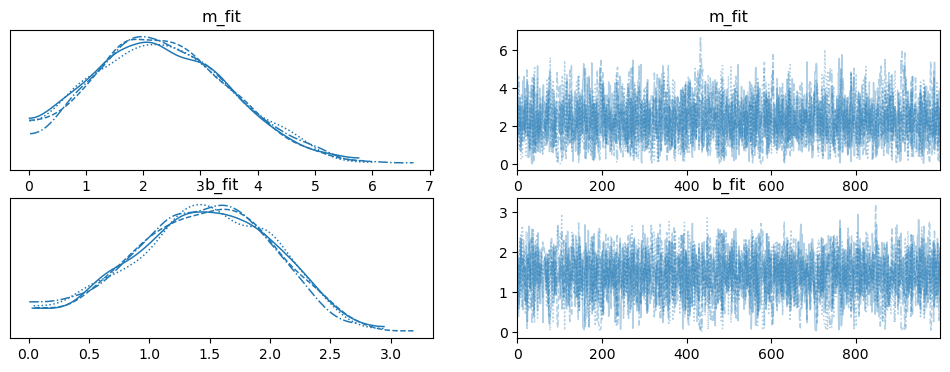

In [18]:
az.plot_trace(idata,var_names=['m_fit','b_fit'])

/home/corcoted/gitrepos/corcoted.github.io/env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


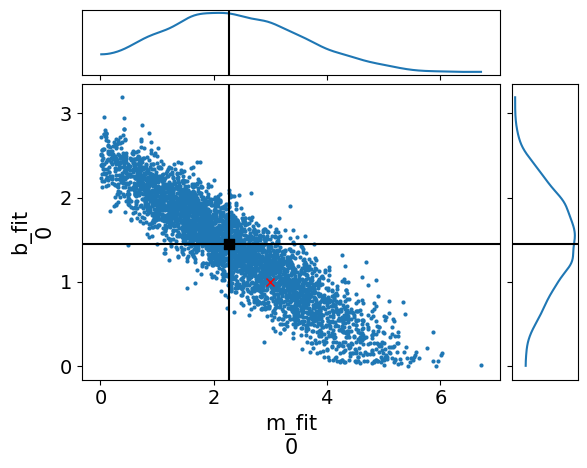

In [19]:
axes=az.plot_pair(idata,var_names=['m_fit','b_fit'],marginals=True,point_estimate='median')
axes[1,0].plot(m,b,'rx') # HACK manually plot ground truth

In [20]:
az.summary(idata,var_names=['x_latent'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x_latent[0],0.355,0.098,0.180,0.547,0.001,0.001,6359.0,2931.0,1.0
x_latent[1],0.375,0.097,0.197,0.559,0.001,0.001,6115.0,2683.0,1.0
x_latent[2],0.654,0.095,0.484,0.844,0.001,0.001,8155.0,2696.0,1.0
x_latent[3],0.421,0.094,0.246,0.603,0.001,0.001,5292.0,3017.0,1.0
x_latent[4],0.138,0.095,-0.033,0.315,0.001,0.001,6140.0,3175.0,1.0
x_latent[5],0.594,0.095,0.409,0.769,0.001,0.001,6409.0,2772.0,1.0
x_latent[6],0.669,0.096,0.499,0.857,0.001,0.001,6974.0,2455.0,1.0
x_latent[7],0.390,0.093,0.213,0.559,0.001,0.001,7050.0,2866.0,1.0
x_latent[8],0.631,0.096,0.445,0.806,0.001,0.001,6460.0,2921.0,1.0
x_latent[9],0.304,0.097,0.125,0.488,0.001,0.001,6301.0,2745.0,1.0


Text(0.5, 1.0, 'Sampler residuals for x')

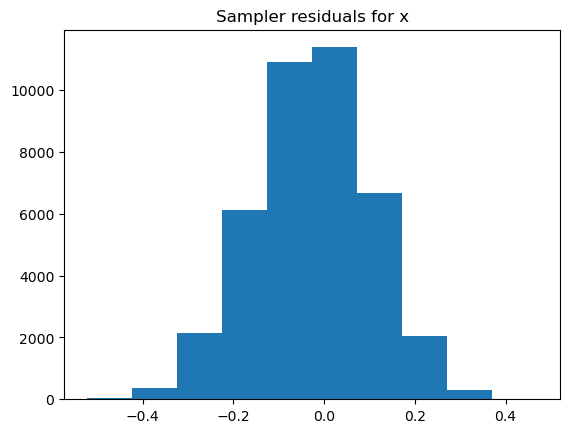

In [21]:
plt.hist((idata['posterior']['x_latent'].values.reshape([-1,10])-x_true).flatten())
plt.title("Sampler residuals for x")

Text(0.5, 1.0, 'Sampler residuals for y')

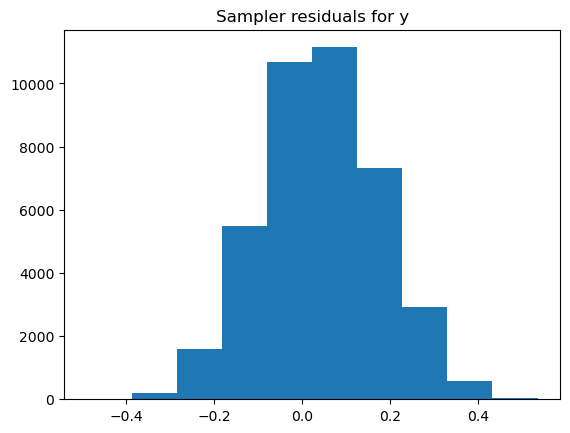

In [22]:
plt.hist((idata['posterior']['y_latent'].values.reshape([-1,10])-y_true).flatten())
plt.title("Sampler residuals for y")

In [23]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

/tmp/ipykernel_9258/2774566049.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))


Plot the posterior predictive.  Does it jive with the data?

In [24]:
m_list = np.array(idata['posterior']['m_fit']).flatten()
b_list = np.array(idata['posterior']['b_fit']).flatten()

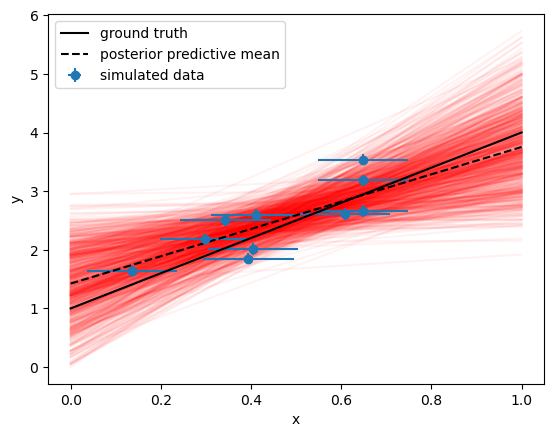

In [26]:
# plot the data and the pp
x_limits=np.array([0.0,1.0])
fig, ax=plt.subplots()
for i in range(4000//5):
    ax.plot(x_limits,f_true(x_limits,m_list[::5][i],b_list[::5][i]),'r',alpha=0.05, label='_nolegend_')
ax.errorbar(x=x_data,y=y_data,xerr=sigma_x,yerr=sigma_y,fmt='o',label='simulated data')
ax.set_xlabel('x')
ax.set_ylabel("y")
ax.plot(x_limits,f_true(x_limits,m,b),'k',label='ground truth')
ax.plot(x_limits,f_true(x_limits,m_list.mean(),b_list.mean()),'k--',label="posterior predictive mean")
ax.legend()


## TODO
Calculate the traditional ODR fit and compare.

Or... calculate Chi2

In [29]:
#chi2 for the ground truth
np.sum((y_data-m*x_data-b)**2/(sigma_y**2 +m**2*sigma_x*2))

0.6499884674110865

In [30]:
#chi2 for the posterior predictive mean
np.sum((y_data-m_list.mean()*x_data-b_list.mean())**2/(sigma_y**2 +m_list.mean()**2*sigma_x*2))

0.9713930891999197

Not as good...  I would expect the convergence to be better :(